In [51]:
import xarray as xr
import numpy as np
import requests as rq
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [225]:
# OI Grid
lon_min = 295.                                           # domain min longitude
lon_max = 305.                                           # domain max longitude
lat_min = 33.                                            # domain min latitude
lat_max = 43.                                            # domain max latitude
time_min = np.datetime64('2017-01-01')                # domain min time
time_max = np.datetime64('2017-01-31') #np.datetime64('2017-12-31')                # domain max time
dx = 0.2                                               # zonal grid spatial step (in degree)
dy = 0.2                                                 # meridional grid spatial step (in degree)
dt = np.timedelta64(1, 'D')                           # temporal grid step

glon = np.arange(lon_min, lon_max + dx, dx)           # output OI longitude grid
glat = np.arange(lat_min, lat_max + dy, dy)           # output OI latitude grid
gtime = np.arange(time_min, time_max + dt, dt)        # output OI time grid

 

In [226]:
glon.shape, glat.shape, gtime.shape

((51,), (52,), (31,))

### OI Params

In [227]:
# OI parameters
Lx = 1.                                                  # Zonal decorrelation scale (in degree)
Ly = 1.                                                  # Meridional decorrelation scale (in degree)
Lt = 7.                                                  # Temporal decorrelation scale (in days)
noise = 0.05  

## OI Grid

In [228]:
def create_oi_grid(glon, glat, gtime):
    """
    
    """
    

    nx = len(glon)
    ny = len(glat)
    nt = len(gtime)

    # define & initialize ssh array
    gssh_mu = np.empty((nt, ny, nx))
    gssh_var = np.empty((nt, ny, nx))
    nobs = np.empty(nt)

    # Make 2D grid
    glon2, glat2 = np.meshgrid(glon, glat)
    fglon = glon2.flatten()
    fglat = glat2.flatten()

    ng = len(fglat) # number of grid points
    vtime = (gtime - gtime[0]) / np.timedelta64(1, 'D')
    
    
    ds_oi_grid = xr.Dataset({'gssh_mu' : (('time', 'lat', 'lon'), gssh_mu), 
                             'gssh_var' : (('time', 'lat', 'lon'), gssh_var),
                             'glon2' : (('lat', 'lon'), glon2),
                             'glat2' : (('lat', 'lon'), glat2),
                             'fglon' : (('ng'), fglon),
                             'fglat' : (('ng'), fglat),
                             'nobs' : (('time'), nobs)},
                              coords={'gtime': (vtime).astype(np.float),
                                      'time': gtime,
                                      'lat': glat, 
                                      'lon': glon,
                                      'ng': np.arange(ng)})

    return ds_oi_grid

In [229]:
ds_oi_grid = create_oi_grid(glon, glat, gtime)
ds_oi_grid

<xarray.Dataset>
Dimensions:   (time: 31, lat: 52, lon: 51, ng: 2652, gtime: 31)
Coordinates:
  * gtime     (gtime) float64 0.0 1.0 2.0 3.0 4.0 ... 26.0 27.0 28.0 29.0 30.0
  * time      (time) datetime64[ns] 2017-01-01 2017-01-02 ... 2017-01-31
  * lat       (lat) float64 33.0 33.2 33.4 33.6 33.8 ... 42.6 42.8 43.0 43.2
  * lon       (lon) float64 295.0 295.2 295.4 295.6 ... 304.4 304.6 304.8 305.0
  * ng        (ng) int64 0 1 2 3 4 5 6 7 ... 2645 2646 2647 2648 2649 2650 2651
Data variables:
    gssh_mu   (time, lat, lon) float64 900.0 900.0 900.0 ... 2.271e-05 0.008938
    gssh_var  (time, lat, lon) float64 9.664e-219 9.344e-219 ... 1.609e-225
    glon2     (lat, lon) float64 295.0 295.2 295.4 295.6 ... 304.6 304.8 305.0
    glat2     (lat, lon) float64 33.0 33.0 33.0 33.0 ... 43.2 43.2 43.2 43.2
    fglon     (ng) float64 295.0 295.2 295.4 295.6 ... 304.4 304.6 304.8 305.0
    fglat     (ng) float64 33.0 33.0 33.0 33.0 33.0 ... 43.2 43.2 43.2 43.2 43.2
    nobs      (time) float64 8.482e-320 8.482e-320 ... 8.496e-320 8.496e-320

## Observations

In [230]:
file_path = "/Volumes/EMANS_HDD/data/2021a_ose"

inputs = [f'{file_path}/dt_gulfstream_alg_phy_l3_20161201-20180131_285-315_23-53.nc', 
          f'{file_path}/dt_gulfstream_j3_phy_l3_20161201-20180131_285-315_23-53.nc', 
          f'{file_path}/dt_gulfstream_s3a_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{file_path}/dt_gulfstream_h2g_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{file_path}/dt_gulfstream_j2g_phy_l3_20161201-20180131_285-315_23-53.nc',
          f'{file_path}/dt_gulfstream_j2n_phy_l3_20161201-20180131_285-315_23-53.nc'] 

In [231]:
import hvplot.xarray

### Convert to Grid

In [232]:
def create_sla_grid(gdata, glon, glat, gtime):
    """
    
    """
    

    nx = len(glon)
    ny = len(glat)
    nt = len(gtime)

    # define & initialize ssh array
    gssh_mu = np.empty((nt, ny, nx))
    gssh_var = np.empty((nt, ny, nx))
    nobs = np.empty(nt)

    # Make 2D grid
    glon2, glat2 = np.meshgrid(glon, glat)
    fglon = glon2.flatten()
    fglat = glat2.flatten()

    ng = len(fglat) # number of grid points
    vtime = (gtime - gtime[0]) / np.timedelta64(1, 'D')
    
    
    ds_oi_grid = xr.Dataset({'gssh_mu' : (('time', 'lat', 'lon'), gssh_mu), 
                             'gssh_var' : (('time', 'lat', 'lon'), gssh_var),
                             'glon2' : (('lat', 'lon'), glon2),
                             'glat2' : (('lat', 'lon'), glat2),
                             'fglon' : (('ng'), fglon),
                             'fglat' : (('ng'), fglat),
                             'nobs' : (('time'), nobs)},
                              coords={'gtime': (vtime).astype(np.float),
                                      'time': gtime,
                                      'lat': glat, 
                                      'lon': glon,
                                      'ng': np.arange(ng)})

    return ds_oi_grid

In [233]:
ds = xr.open_dataset(inputs[0])
ds

<xarray.Dataset>
Dimensions:         (time: 404083)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-01T08:49:09.733021952 ... 2...
    longitude       (time) float64 ...
    latitude        (time) float64 ...
Data variables:
    cycle           (time) float64 ...
    track           (time) float64 ...
    dac             (time) float32 ...
    lwe             (time) float32 ...
    mdt             (time) float32 ...
    ocean_tide      (time) float64 ...
    sla_filtered    (time) float32 ...
    sla_unfiltered  (time) float32 ...
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [234]:
ds_oi_grid.gssh_mu.hvplot.image(width=500, height=400)

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [235]:
central_date = np.datetime64('2017-01-15')
delta_t = np.timedelta64(5, 'D')

In [236]:
coarsening = {'time': 5}

In [237]:
def preprocess(ds):
    return ds.coarsen(coarsening, boundary="trim").mean()

ds_obs = xr.open_mfdataset(inputs, combine='nested', concat_dim='time', parallel=True, preprocess=preprocess) #.sortby('time')
#ds_obs = ds_obs.coarsen(coarsening, boundary="trim").mean().sortby('time')
ds_obs = ds_obs.sortby('time')

/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is generating 3806 times more chunks
  return self.array[key]
/Users/eman/miniconda3/envs/4dvarjax/lib/python3.9/site-packages/xarray/core/indexing.py:1227: PerformanceWarning: Slicing with an out-of-order index is

In [238]:
# correct lon if domain is between [-180:180]
if lon_min < 0:
    ds_obs['longitude'] = xr.where(ds_obs['longitude'] >= 180., ds_obs['longitude']-360., ds_obs['longitude'])

In [239]:
# get maximum coordinate values
lon_min = ds_oi_grid.lon.min().values
lon_max = ds_oi_grid.lon.max().values
lat_min = ds_oi_grid.lat.min().values
lat_max = ds_oi_grid.lat.max().values
time_min = ds_oi_grid.time.min().values
time_max = ds_oi_grid.time.max().values

    

In [240]:
def get_max_coords():
    
    return None

In [241]:
# subset time
ds_obs_subset = ds_obs.sel(time=slice(time_min - np.timedelta64(int(2*Lt), 'D'), 
                               time_max + np.timedelta64(int(2*Lt), 'D')), drop=True)

In [242]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 55887)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-18T00:30:53.055458764 ... 2...
    longitude       (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(44,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(44,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [243]:
# ds_obs_subset.time[:7]

In [244]:
# ds_obs_subset.resample(time="1D").mean(dim="time")

In [245]:
# ds_obs_subset.time

In [246]:
# subset lat/lon values
ds_obs_subset = ds_obs_subset.where(
    (ds_obs_subset['longitude'] >= lon_min - Lx) & 
    (ds_obs_subset['longitude'] <= lon_max + Lx) &
    (ds_obs_subset['latitude'] >= lat_min - Ly) &
    (ds_obs_subset['latitude'] <= lat_max + Ly),
    drop=True
)

In [247]:
eval("1+2/3")

1.6666666666666665

In [248]:
time_min

numpy.datetime64('2017-01-01T00:00:00.000000000')

In [249]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 11316)
Coordinates:
  * time            (time) datetime64[ns] 2016-12-18T01:11:31.083212748 ... 2...
    longitude       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

In [250]:
def add_vtime(ds, time_min: np.datetime64):
    vtime = (ds['time'].values - time_min) / np.timedelta64(1, 'D')
    return ds.assign_coords({'time': vtime})

In [251]:
type(time_min)

numpy.datetime64

In [252]:
time_min = np.datetime64('2017-01-01')
ds_obs_subset = add_vtime(ds_obs_subset, time_min)

In [253]:
# # add vtime coord
# vtime = (ds_obs_subset['time'].values - time_min) / np.timedelta64(1, 'D')
# ds_obs_subset = ds_obs_subset.assign_coords({'time': vtime})



In [254]:
ds_obs_subset = ds_obs_subset.dropna(dim='time')

In [255]:
ds_obs_subset

<xarray.Dataset>
Dimensions:         (time: 11316)
Coordinates:
  * time            (time) float64 -13.95 -13.81 -13.65 ... 43.95 43.95 43.95
    longitude       (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    latitude        (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
Data variables:
    cycle           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    track           (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    dac             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    lwe             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    mdt             (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    ocean_tide      (time) float64 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_filtered    (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
    sla_unfiltered  (time) float32 dask.array<chunksize=(1,), meta=np.ndarray>
Attributes: (12/44)
    Conventions:                     CF-1.6
    Metadata_Conventions:            Unidata Dataset Discovery v1.0
    cdm_data_type:                   Swath
    comment:                         Sea surface height measured by altimeter...
    contact:                         servicedesk.cmems@mercator-ocean.eu
    creator_email:                   servicedesk.cmems@mercator-ocean.eu
    ...                              ...
    summary:                         SSALTO/DUACS Delayed-Time Level-3 sea su...
    time_coverage_duration:          P23H16M26.458585S
    time_coverage_end:               2016-01-01T23:06:57Z
    time_coverage_resolution:        P1S
    time_coverage_start:             2015-12-31T23:50:30Z
    title:                           DT Altika Drifting Phase Global Ocean Al...

## OI Algorithm

$$
\mathbf{y} = \mathbf{Hx} + \boldsymbol{\epsilon}
$$

where:

* $\mathbf{x} \in \mathbb{R}^{D_\mathbf{x}}$ - the unknown state to be estimated
* $\mathbf{y} \in \mathbb{R}^{D_\mathbf{y}}$ - the observations
* $\mathbf{H} \in \mathbb{R}^{D_\mathbf{y} \times D_\mathbf{x}}$ - the linear observation operator
* $\boldsymbol{\epsilon} \in \mathbb{R}^{D_\mathbf{y}}$ - the independent observation error

---

$$
\mathbf{x} = \mathbf{Ky}
$$

where:

* $\mathbf{K} \in \mathbb{R}^{D_\mathbf{x} \times D_\mathbf{y}}$ - Kalman Gain

$$
\mathbf{K} = \mathbf{BH}^\top \left( \mathbf{HBH}^\top\right)^{-1}
$$

where:

* $\mathbf{B} \in \mathbb{R}^{D_\mathbf{x} \times D_\mathbf{x}}$ - covariance of $\mathbf{x}$


In [34]:
from typing import NamedTuple
from dataclasses import dataclass

@dataclass
class Dimensions:
    lat : int
    lon : int
    time : int
    
    def coord_vector(self):
        lat = np.atleast_2d(lat)
        lon = np.atleast_2d(lon)
        time = np.atleast_2d(time)
        
        return np.vstack([time, lat, lon])
@dataclass
class GeoData(Dimensions):
    data: np.ndarray

In [35]:
from tqdm.notebook import tqdm, trange

* OI Grid
* Observation Grid

In [36]:
len(gtime)

31

In [39]:
# loop through the time dimension

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    obs_values = ds_obs_subset.sla_unfiltered.values[ind1]
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
#     # loop through observations
#     for i_obs in trange(n_obs):
        
#         # BHt (Dx x Dy)
#         t1 = ((state_data.time - obs_data.time[i_obs]) / Lt)**2
#         t2 = ((state_data.lon - obs_data.lon[i_obs]) / Lx)**2
#         t3 = ((state_data.lat - obs_data.lat[i_obs]) / Ly)**2
#         BHt[:, i_obs] = np.exp(-t1 - t2 - t3)
        
#         # HBHt (Dx x Dy)
#         t1 = ((obs_data.time - obs_data.time[i_obs]) / Lt)**2
#         t2 = ((obs_data.lon - obs_data.lon[i_obs]) / Lx)**2
#         t3 = ((obs_data.lat - obs_data.lat[i_obs]) / Ly)**2
#         HBHt[:, i_obs] = np.exp(-t1 - t2 - t3)

    t1 = ((np.array([state_data.time])[:, None] - obs_data.time[None, :]) / Lt)**2
    t2 = ((state_data.lon[:, None] - obs_data.lon[None, :]) / Lx)**2
    t3 = ((state_data.lat[:, None] - obs_data.lat[None, :]) / Ly)**2
    BHt = np.exp(-t1 - t2 - t3)
    
    t1 = ((obs_data.time[:, None] - obs_data.time[None, :]) / Lt)**2
    t2 = ((obs_data.lon[:, None] - obs_data.lon[None, :]) / Lx)**2
    t3 = ((obs_data.lat[:, None] - obs_data.lat[None, :]) / Ly)**2
    HBHt = np.exp(-t1 - t2 - t3)
    
    R = np.diag(np.ones(n_obs) * noise **2)
    
    # 
    Coo = HBHt + R
    
    Mi = np.linalg.inv(Coo)
    
    Iw = np.matmul(BHt, Mi)
    
    sol = Iw @ obs_data.data
    
    # save into data arrays
    ds_oi_grid.gssh_mu[i_time, :, :] = sol.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.nobs[i_time] = n_obs
    # break

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [40]:
ds_oi_grid.gssh.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh)

---

$$
k(\mathbf{x}, \mathbf{y}) = \exp \left( - \gamma ||\mathbf{x} - \mathbf{y}||_2^2 \right)
$$

---

$$
\mathbf{K} = \mathbf{K}_{time} + \mathbf{K}_{lat} + \mathbf{K}_{lon}
$$

### Kernel Ridge Regression

In [41]:
def add_dim(x):
    if x.ndim < 2:
        x = x.reshape(-1, 1)
    return x

In [276]:
from sklearn.gaussian_process.kernels import StationaryKernelMixin, NormalizedKernelMixin, Kernel, Hyperparameter

class SpatioTemporalKernel(StationaryKernelMixin, NormalizedKernelMixin, Kernel):
    
    def __init__(
        self, 
        spatial_length_scale=1.0, 
        temporal_length_scale=1.0, 
        spatial_length_scale_bounds=(1e-5, 1e5),
        temporal_length_scale_bounds=(1e-5, 1e5),
    ):
        self.spatial_length_scale = spatial_length_scale
        self.spatial_length_scale_bounds = spatial_length_scale_bounds
        self.temporal_length_scale = temporal_length_scale
        self.temporal_length_scale_bounds = temporal_length_scale_bounds
        
    @property
    def hyperparameter_spatial_length_scale(self):
        """Returns the length scale"""
        return Hyperparameter("spatial_length_scale", "numeric", self.spatial_length_scale_bounds)
    
    @property
    def hyperparameter_temporal_length_scale(self):
        """Returns the length scale"""
        return Hyperparameter("temporal_length_scale", "numeric", self.temporal_length_scale_bounds)
    
    def __call__(self, X, Y=None, eval_gradient=False):
        
        if Y is None:
            K = spatiotemporal_kernel(X, X, self.temporal_length_scale, self.spatial_length_scale)
        else:
            K = spatiotemporal_kernel(X, Y, self.temporal_length_scale, self.spatial_length_scale)
            
        if eval_gradient:
            raise NotImplementedError()
            
        else:
            return K

In [42]:
from sklearn.metrics.pairwise import rbf_kernel

def temporal_gauss_kernel(x_time_coords, y_time_coords, time_scale):
    gamma = 1 / time_scale ** 2
    x_time_coords = add_dim(x_time_coords)
    y_time_coords = add_dim(y_time_coords)
    
    k = rbf_kernel(x_time_coords, y_time_coords, gamma=gamma)
    return k

def spatial_gauss_kernel(x_spatial_coords, y_spatial_coords, spatial_scale):
    gamma = 1 / spatial_scale ** 2
    x_spatial_coords = add_dim(x_spatial_coords)
    y_spatial_coords = add_dim(y_spatial_coords)
    k = rbf_kernel(x_spatial_coords, y_spatial_coords, gamma=gamma)
    return k


In [43]:
def spatiotemporal_kernel(x_coords, y_coords, time_scale, spatial_scale):
    # print(x_coords.shape, y_coords.shape)
    k1 = temporal_gauss_kernel(x_coords[:, 0], y_coords[:, 0], time_scale)
    k2 = spatial_gauss_kernel(x_coords[:, 1:], y_coords[:, 1:], spatial_scale)
    
    return k1 * k2

In [44]:
# get observation data
obs_data = GeoData(
    lat=ds_obs_subset.latitude.values[ind1],
    lon=ds_obs_subset.longitude.values[ind1],
    time=ds_obs_subset.time.values[ind1],
    data=ds_obs_subset.sla_unfiltered.values[ind1]
)

In [45]:
from einops import repeat

def broadcast_timesteps(t, n_steps):
    t = repeat(t, "1 ... -> N ...", N=n_steps)
    return t

In [46]:

@dataclass
class Dimensions:
    lat : int
    lon : int
    time : int
    
    def coord_vector(self):
        lat = add_dim(self.lat)
        lon = add_dim(self.lon)
        time = add_dim(self.time)
        if time.shape[0] != lat.shape[0]:
            time = repeat(time, "1 ... -> N ...", N=lat.shape[0])
        
        # print(time.shape, lat.shape, lon.shape)
        vec = np.hstack([time, lat, lon])
        assert vec.shape[1] == 3
        return vec
    
@dataclass
class GeoData(Dimensions):
    data: np.ndarray

In [47]:
# get observation data
obs_data = GeoData(
    lat=ds_obs_subset.latitude.values[ind1],
    lon=ds_obs_subset.longitude.values[ind1],
    time=ds_obs_subset.time.values[ind1],
    data=ds_obs_subset.sla_unfiltered.values[ind1]
)

t_ = obs_data.coord_vector()
t_.shape

(5358, 3)

In [274]:
kernel = SpatioTemporalKernel(7., 1.)
k = kernel(t_, t_)
k.shape

(5358, 5358)

In [48]:
k = spatiotemporal_kernel(t_, t_, 7., 1.)

In [49]:

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    
    ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 1.))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )

    obs_data_t = GeoData(
        lat=ds_obs_subset.latitude.values[ind_t],
        lon=ds_obs_subset.longitude.values[ind_t],
        time=ds_obs_subset.time.values[ind_t],
        data=ds_obs_subset.sla_unfiltered.values[ind_t]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
    # CROSS KERNEL
    
    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()
    
    BHt = spatiotemporal_kernel(state_coords, obs_coords, Lt, Lx)
    
    # HBHt = k1 * k2 * k3
    HBHt = spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)
    
    R = np.diag(np.ones(n_obs) * noise **2)
    
    # 
    Coo = HBHt + R
    
    Mi = np.linalg.inv(Coo)
    
    Iw = np.matmul(BHt, Mi)
    
    sol = Iw @ obs_data.data
    
    # save into data arrays
    ds_oi_grid.gssh[i_time, :, :] = sol.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.nobs[i_time] = n_obs

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [279]:
ds_oi_grid.gssh.hvplot.image(width=500, height=400, cmap="RdBu_r")

AttributeError: 'Dataset' object has no attribute 'gssh'

In [256]:
from sklearn.kernel_ridge import KernelRidge

In [282]:

for i_time in trange(len(gtime)):
    
    # get indices where there are observations
    ind1 = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 2. * Lt))[0]
    
    ind_t = np.where((np.abs(ds_obs_subset.time.values - ds_oi_grid.gtime.values[i_time]) < 1.))[0]
    n_obs = len(ind1)
    
    # # initialize matrices
    # # (D_x x D_y)
    # BHt = np.empty((len(ds_oi_grid.ng), n_obs))
    # # (D_y x D_y)
    # HBHt = np.empty((n_obs, n_obs))
    
    
    # get observation data
    obs_data = GeoData(
        lat=ds_obs_subset.latitude.values[ind1],
        lon=ds_obs_subset.longitude.values[ind1],
        time=ds_obs_subset.time.values[ind1],
        data=ds_obs_subset.sla_unfiltered.values[ind1]
    )

    obs_data_t = GeoData(
        lat=ds_obs_subset.latitude.values[ind_t],
        lon=ds_obs_subset.longitude.values[ind_t],
        time=ds_obs_subset.time.values[ind_t],
        data=ds_obs_subset.sla_unfiltered.values[ind_t]
    )
    
    # get state data
    state_data = Dimensions(
        lat=ds_oi_grid.fglat.values,
        lon=ds_oi_grid.fglon.values,
        time=ds_oi_grid.gtime.values[i_time]
    )
    
    
    # DATA KERNEL
    
    state_coords = state_data.coord_vector()
    obs_coords = obs_data.coord_vector()
    
    kernel = SpatioTemporalKernel(temporal_length_scale=7., spatial_length_scale=1.)
    
    clf_model = KernelRidge(kernel=kernel, alpha=noise ** 2)
    
    # # compute kernel function
    # K =  spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)
    
    clf_model.fit(obs_coords, obs_data.data)
    
    # CROSS KERNEL
    
    y_pred = clf_model.predict(state_coords)
    
    
    # save into data arrays
    ds_oi_grid.gssh_mu[i_time, :, :] = y_pred.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
    ds_oi_grid.nobs[i_time] = n_obs

print("Done!")

  0%|          | 0/31 [00:00<?, ?it/s]

Done!


In [283]:
ds_oi_grid.gssh_mu.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh_mu)

In [259]:
from sklearn.linear_model._ridge import _solve_cholesky_kernel
from scipy.linalg import cho_factor, cho_solve, solve_triangular

In [260]:
# computer kernel matrix
K = spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)

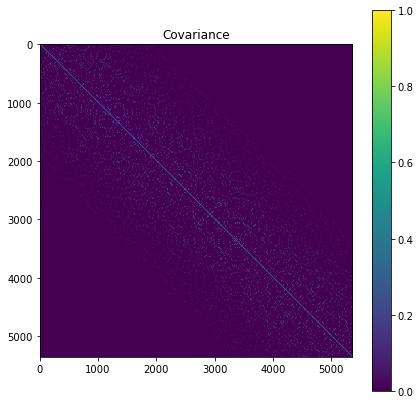

In [261]:
fig, ax = plt.subplots(figsize=(7, 7))

img = ax.imshow(K, cmap="viridis")
ax.set(title="Covariance")
plt.colorbar(img)
plt.show()

**Solving**

$$
\boldsymbol{\alpha} = (\mathbf{K_{XX}} + \sigma^2 \mathbf{I})^{-1} \mathbf{y}
$$

We can use the cholesky decomposition.

$$
\begin{aligned}
\mathbf{L} &= \text{cholesky}(\mathbf{K_{XX}} + \sigma^2 \mathbf{I}) \\
\mathbf{L} \boldsymbol{\alpha} &= \mathbf{y}
\end{aligned}
$$

In [262]:
def cholesky_solve(K, y):
    L = cho_factor(K, lower=True)
    return cho_solve(L, y), L

In [327]:
%%time

# computer kernel matrix
K = spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)
y = obs_data.data[:, None]
alpha = noise ** 2
copy = True
sample_weight = None

# compute weights
K_gp = K + alpha * np.eye(K.shape[0])

# compute kernel
weights, L = cholesky_solve(K_gp, y)


CPU times: user 6.09 s, sys: 1.06 s, total: 7.14 s
Wall time: 1.76 s


In [328]:
%%time

# make predictions
K_trans = spatiotemporal_kernel(state_coords, obs_coords, Lt, Lx)

# predictive mean
y_pred = np.dot(K_trans, weights)

# predictive variance
# K_star = spatiotemporal_kernel(state_coords, state_coords, Lt, Lx)
y_var = np.ones(K_trans.shape[0])

v = solve_triangular(L[0], K_trans.T, lower=True)
y_var = y_var + np.einsum("ij,ji->i", v.T, v)

CPU times: user 8.04 s, sys: 894 ms, total: 8.94 s
Wall time: 1.4 s


In [329]:
y_pred = kernel_ridge_tuned.predict(state_coords)

$$
\begin{aligned}
\boldsymbol{m}(\mathbf{x}^*) &= \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*) \boldsymbol{\alpha} \\
\boldsymbol{\sigma}^2(\mathbf{x}^*) &= \boldsymbol{k}(\mathbf{x}^*, \mathbf{x'}^*) - \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*)(\mathbf{K_{XX}} + \sigma^2 \mathbf{I})^{-1} \boldsymbol{k}_{\mathbf{x}}(\mathbf{x}^*)^\top
\end{aligned}
$$

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37712/776376319.py:2: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r', aspect="equal")
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37712/776376319.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_var.squeeze(), cmap='RdBu_r', aspect="equal")


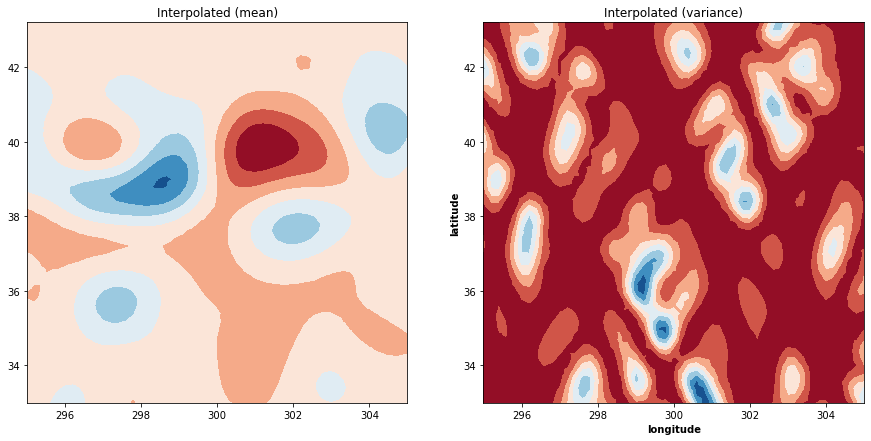

In [330]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
ax[0].tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r', aspect="equal")
ax[1].tricontourf(state_data.lon, state_data.lat, y_var.squeeze(), cmap='RdBu_r', aspect="equal")
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Interpolated (mean)')
ax[1].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

#### Samples

We can calculate the conditional GP posterior from the above mean and covariance equations. Then we can sample from a Normal distribution


$$
\mathbf{x}' \sim \mathcal{N}(\mathbf{x}^* | \boldsymbol{m}(\mathbf{x}^*), \boldsymbol{\Sigma}(\mathbf{x}^*, \mathbf{x'}^*)
$$

In [266]:
%%time

nrows = 4
ncols = 4
n_samples = nrows * ncols

# random state
rng = np.random.RandomState(123)

# make predictions (full cov)
# predictive mean
y_mu = np.dot(K_trans, weights)

# predictive variance
K_star = spatiotemporal_kernel(state_coords, state_coords, Lt, Lx)
v = solve_triangular(L[0], K_trans.T, lower=True)
y_cov = K_star - v.T @ v

# generate samples
y_samples = rng.multivariate_normal(y_mu.squeeze(), y_cov, n_samples).T

CPU times: user 1min 2s, sys: 10.8 s, total: 1min 12s
Wall time: 10.9 s


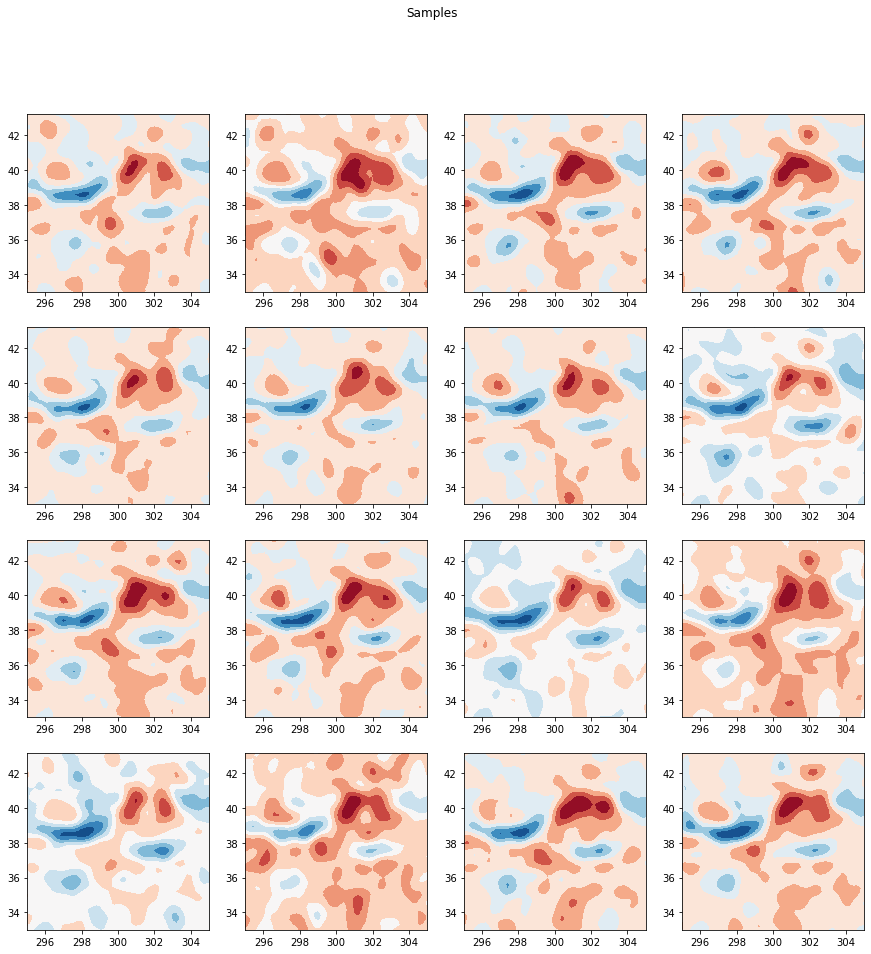

In [267]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
n = 0
for i, iax in enumerate(axs.reshape(-1)):

    iax.tricontourf(state_data.lon, state_data.lat, y_samples[:, i].squeeze(), cmap='RdBu_r')
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.show()

### Trained

In [349]:
%%time
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform
from scipy.stats.distributions import uniform

param_distributions = {
    "alpha": loguniform(1e-3, 1e1),
    "kernel__spatial_length_scale": loguniform(0.1, 100.0),
    "kernel__temporal_length_scale": loguniform(1.0, 100.0),
}
kernel_ridge_tuned = RandomizedSearchCV(
    clf_model,
    param_distributions=param_distributions,
    n_iter=30,
    random_state=0,
    verbose=2
)

kernel_ridge_tuned.fit(obs_coords, obs_data.data)

Fitting 5 folds for each of 30 candidates, totalling 150 fits
[CV] END alpha=0.15676677195506059, kernel__spatial_length_scale=13.981961408994046, kernel__temporal_length_scale=16.051911333587626; total time=   1.1s
[CV] END alpha=0.15676677195506059, kernel__spatial_length_scale=13.981961408994046, kernel__temporal_length_scale=16.051911333587626; total time=   1.1s
[CV] END alpha=0.15676677195506059, kernel__spatial_length_scale=13.981961408994046, kernel__temporal_length_scale=16.051911333587626; total time=   1.1s
[CV] END alpha=0.15676677195506059, kernel__spatial_length_scale=13.981961408994046, kernel__temporal_length_scale=16.051911333587626; total time=   1.1s
[CV] END alpha=0.15676677195506059, kernel__spatial_length_scale=13.981961408994046, kernel__temporal_length_scale=16.051911333587626; total time=   1.1s
[CV] END alpha=0.15119336467640998, kernel__spatial_length_scale=1.8662266976517967, kernel__temporal_length_scale=19.578897201212996; total time=   1.1s
[CV] END alpha

RandomizedSearchCV(estimator=KernelRidge(alpha=0.0025000000000000005,
                                         kernel=SpatioTemporalKernel(0, 1.95)),
                   n_iter=30,
                   param_distributions={'alpha': <scipy.stats._distn_infrastructure.rv_frozen object at 0x19a59d7f0>,
                                        'kernel__spatial_length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x19a58db50>,
                                        'kernel__temporal_length_scale': <scipy.stats._distn_infrastructure.rv_frozen object at 0x19a59d580>},
                   random_state=0, verbose=2)

In [359]:
kernel_ridge_tuned.best_params_

{'alpha': 0.18467402585753676,
 'kernel__spatial_length_scale': 0.6254152586876391,
 'kernel__temporal_length_scale': 11.130024156730636}

In [351]:
y_pred = kernel_ridge_tuned.predict(state_coords)

/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37712/577276589.py:2: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r', aspect="equal")


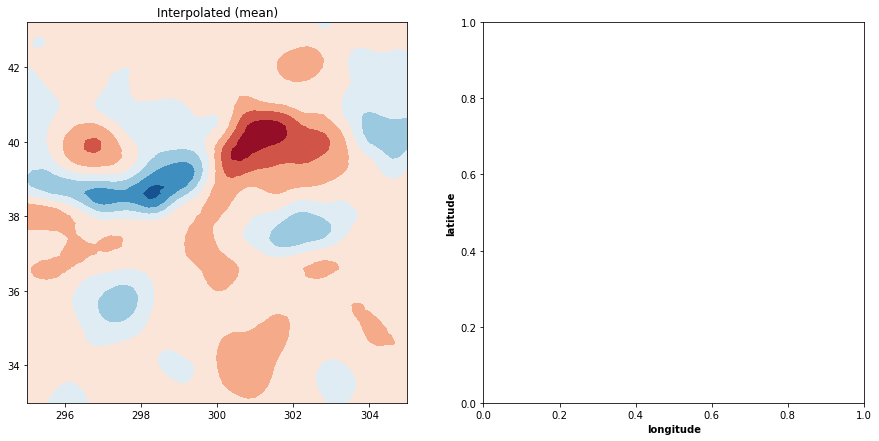

In [352]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
ax[0].tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r', aspect="equal")
# ax[1].tricontourf(state_data.lon, state_data.lat, y_var.squeeze(), cmap='RdBu_r', aspect="equal")
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Interpolated (mean)')
# ax[1].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

In [353]:
clf_model.kernel

SpatioTemporalKernel(0, 1.95)

In [354]:
%%time

# computer kernel matrix
K = spatiotemporal_kernel(
    obs_coords, 
    obs_coords, 
    time_scale=kernel_ridge_tuned.best_params_["kernel__temporal_length_scale"],
    spatial_scale=kernel_ridge_tuned.best_params_["kernel__spatial_length_scale"]
)
y = obs_data.data[:, None]
alpha = kernel_ridge_tuned.best_params_["alpha"]
copy = True
sample_weight = None

# compute weights
K_gp = K + alpha * np.eye(K.shape[0])

# compute kernel
weights, L = cholesky_solve(K_gp, y)

CPU times: user 7.35 s, sys: 1.18 s, total: 8.53 s
Wall time: 1.69 s


In [355]:
%%time

# make predictions
K_trans = spatiotemporal_kernel(
    state_coords, obs_coords, 
    time_scale=kernel_ridge_tuned.best_params_["kernel__temporal_length_scale"],
    spatial_scale=kernel_ridge_tuned.best_params_["kernel__spatial_length_scale"]
)

# predictive mean
y_pred = np.dot(K_trans, weights)

# predictive variance
# K_star = spatiotemporal_kernel(state_coords, state_coords, Lt, Lx)
y_var = np.ones(K_trans.shape[0])

v = solve_triangular(L[0], K_trans.T, lower=True)
y_var = y_var + np.einsum("ij,ji->i", v.T, v)

CPU times: user 8.58 s, sys: 451 ms, total: 9.03 s
Wall time: 1.16 s


/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37712/776376319.py:2: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[0].tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r', aspect="equal")
/var/folders/k9/_v6ywhvj0nq36tpttd3j4mq80000gn/T/ipykernel_37712/776376319.py:3: UserWarning: The following kwargs were not used by contour: 'aspect'
  ax[1].tricontourf(state_data.lon, state_data.lat, y_var.squeeze(), cmap='RdBu_r', aspect="equal")


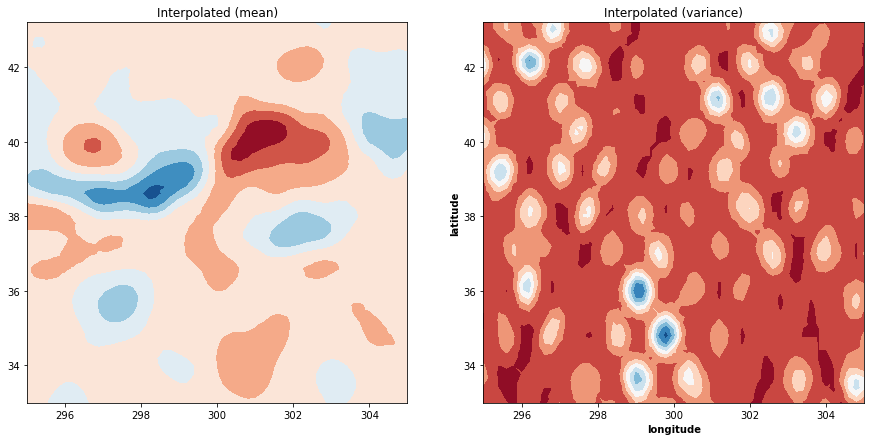

In [356]:
fig, ax = plt.subplots(figsize=(15, 7), ncols=2)
ax[0].tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r', aspect="equal")
ax[1].tricontourf(state_data.lon, state_data.lat, y_var.squeeze(), cmap='RdBu_r', aspect="equal")
# plt.colorbar(img)
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
ax[0].set(title=f'Interpolated (mean)')
ax[1].set(title=f'Interpolated (variance)')
# plt.colorbar(orientation='horizontal')
plt.show()

In [362]:
%%time

nrows = 4
ncols = 4
n_samples = nrows * ncols

# random state
rng = np.random.RandomState(123)

# make predictions (full cov)
K_trans = spatiotemporal_kernel(
    state_coords, obs_coords, 
    time_scale=kernel_ridge_tuned.best_params_["kernel__temporal_length_scale"],
    spatial_scale=kernel_ridge_tuned.best_params_["kernel__spatial_length_scale"]
)
# predictive mean
y_mu = np.dot(K_trans, weights)

# predictive variance
K_star = spatiotemporal_kernel(
    state_coords, state_coords, 
    time_scale=kernel_ridge_tuned.best_params_["kernel__temporal_length_scale"],
    spatial_scale=kernel_ridge_tuned.best_params_["kernel__spatial_length_scale"]
)

# v = cho_solve(L, K_trans.T)
v = solve_triangular(L[0], K_trans.T, lower=True)
y_cov = K_star - v.T @ v

# generate samples
y_samples = rng.multivariate_normal(y_mu.squeeze(), y_cov, n_samples).T

CPU times: user 1min 7s, sys: 11.2 s, total: 1min 18s
Wall time: 10.7 s


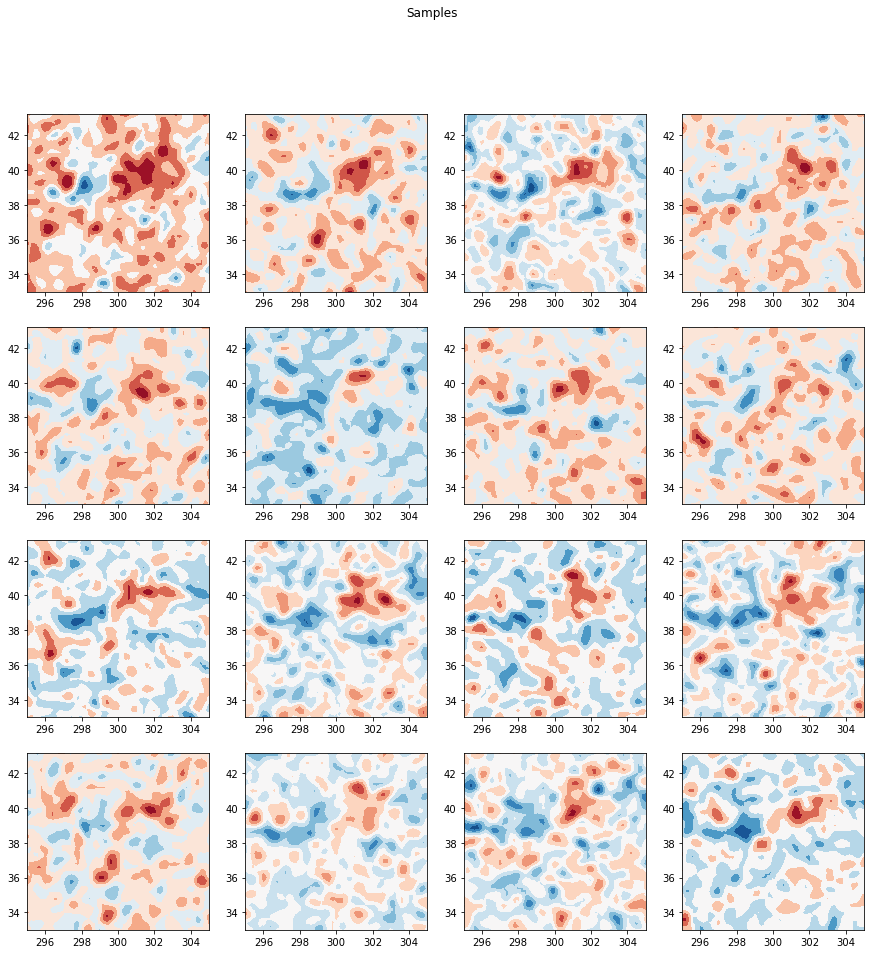

In [363]:
fig, axs = plt.subplots(figsize=(15, 15), nrows=nrows, ncols=ncols)
n = 0
for i, iax in enumerate(axs.reshape(-1)):

    iax.tricontourf(state_data.lon, state_data.lat, y_samples[:, i].squeeze(), cmap='RdBu_r')
    # plt.colorbar(img)
    # ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
    # plt.xlabel('longitude', fontweight='bold')
    # plt.ylabel('latitude', fontweight='bold')
    # plt.colorbar(orientation='horizontal')
        
fig.suptitle("Samples")
plt.show()

In [69]:
# %%time

# # computer kernel matrix
# K = spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)
# y = obs_data.data[:, None]
# alpha = noise ** 2
# copy = True
# sample_weight = None

# # compute weights
# weights = _solve_cholesky_kernel(K, y, alpha, sample_weight, copy)

# # make predictions
# K_trans = spatiotemporal_kernel(state_coords, obs_coords, Lt, Lx)

# y_pred = np.dot(K_trans, weights)

CPU times: user 7.95 s, sys: 1.75 s, total: 9.69 s
Wall time: 2.12 s


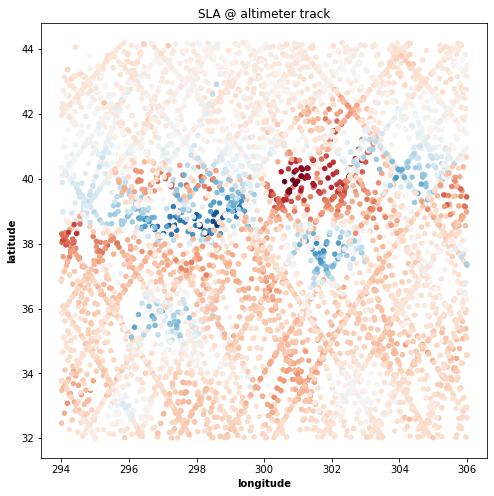

In [268]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(obs_data.lon, obs_data.lat, c=obs_data.data, s=20, cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'SLA @ altimeter track')
# plt.colorbar(orientation='horizontal')
plt.show()

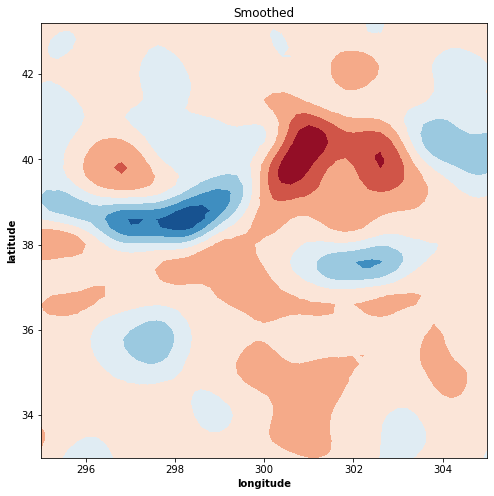

In [91]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.tricontourf(state_data.lon, state_data.lat, y_pred.squeeze(), cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'Smoothed')
# plt.colorbar(orientation='horizontal')
plt.show()

## Kernel Approximation

In [ ]:
L =

In [ ]:
%%time

# computer kernel matrix
K = spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)
y = obs_data.data[:, None]
alpha = noise ** 2
copy = True
sample_weight = None

# approximate the kernel


# compute weights
weights = _solve_cholesky_kernel(K, y, alpha, sample_weight, copy)

# make predictions
K_trans = spatiotemporal_kernel(state_coords, obs_coords, Lt, Lx)

y_pred = np.dot(K_trans, weights)

In [205]:
# kern_fn = lambda x, y: spatiotemporal_kernel(x, y, time_scale=Lt, spatial_scale=Lx)

clf_model = KernelRidge(kernel="precomputed")
    
K =  spatiotemporal_kernel(obs_coords, obs_coords, Lt, Lx)
clf_model.fit(K, obs_data.data)

(5494, 3) (5494, 3)


KernelRidge(kernel='precomputed')

In [206]:
K_trans = spatiotemporal_kernel(state_coords, obs_coords, Lt, Lx)
y_pred = clf_model.predict(K_trans)

(2652, 3) (5494, 3)


In [ ]:
obs_data.lon.shape, obs_data.lat.shape, obs_values.shape

In [207]:
# save into data arrays
ds_oi_grid.gssh[i_time, :, :] = y_pred.reshape(ds_oi_grid.lat.size, ds_oi_grid.lon.size)
ds_oi_grid.nobs[i_time] = n_obs

In [216]:
ds_oi_grid.gssh.hvplot.image(width=500, height=400, cmap="RdBu_r")

:DynamicMap   [time]
   :Image   [lon,lat]   (gssh)

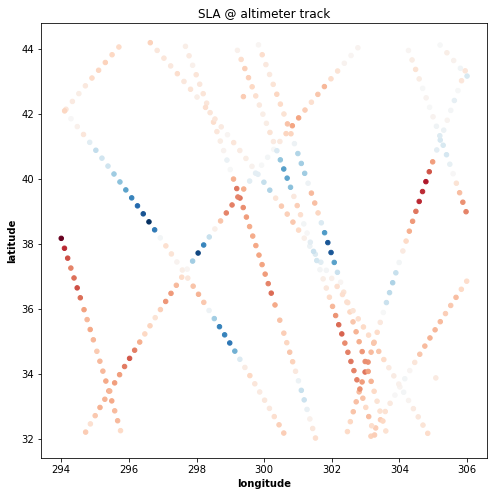

In [208]:
fig, ax = plt.subplots(figsize=(8, 8))
ax.scatter(obs_data_t.lon, obs_data_t.lat, c=obs_data_t.data, s=20, cmap='RdBu_r')
# ax.add_patch(Rectangle((295, 33), 10, 10, fill=None, alpha=1))
plt.xlabel('longitude', fontweight='bold')
plt.ylabel('latitude', fontweight='bold')
plt.title(f'SLA @ altimeter track')
# plt.colorbar(orientation='horizontal')
plt.show()

In [ ]:
ds_oi_grid.gssh.hvplot.image(width=500, height=400, cmap="RdBu_r")

In [60]:
%%time
k1 = temporal_gauss_kernel(state_data.time, obs_data.time, Lt)
k1.shape

CPU times: user 2.62 ms, sys: 3.9 ms, total: 6.53 ms
Wall time: 5.63 ms


(1, 5494)

In [61]:
%%time
k1 = temporal_gauss_kernel(obs_data.time, obs_data.time, Lt)
k1.shape

CPU times: user 298 ms, sys: 103 ms, total: 401 ms
Wall time: 571 ms


(5494, 5494)

#### Spatial Kernel

In [63]:
import time
from sklearn.gaussian_process.kernels import ExpSineSquared
from sklearn.kernel_ridge import KernelRidge

(2652, 5494)

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils.fixes import loguniform

param_distributions = {
    "alpha": loguniform(1e0, 1e3),
    "kernel__length_scale": loguniform(1e-2, 1e2),
    "kernel__periodicity": loguniform(1e0, 1e1),
}
kernel_ridge_tuned = RandomizedSearchCV(
    kernel_ridge,
    param_distributions=param_distributions,
    n_iter=500,
    random_state=0,
)
start_time = time.time()
kernel_ridge_tuned.fit(training_data, training_noisy_target)
print(f"Time for KernelRidge fitting: {time.time() - start_time:.3f} seconds")

In [56]:
from sklearn.metrics.pairwise import rbf_kernel

def temporal_gauss_kernel(x_time_coords, y_time_coords, time_scale):
    gamma = 1 / time_scale ** 2
    x_time_coords = np.atleast_2d(x_time_coords).reshape(-1, 1)
    y_time_coords = np.atleast_2d(y_time_coords).reshape(-1, 1)
    k = rbf_kernel(x_time_coords, y_time_coords, gamma=gamma)
    return k

def spatial_gauss_kernel(x_spatial_coords, y_spatial_coords, spatial_scale):
    gamma = 1 / spatial_scale ** 2
    x_spatial_coords = np.atleast_2d(x_spatial_coords).reshape(-1, 1)
    y_spatial_coords = np.atleast_2d(y_spatial_coords).reshape(-1, 1)
    k = rbf_kernel(x_spatial_coords, y_spatial_coords, gamma=gamma)
    return k

In [48]:
np.atleast_2d(obs_data.time).reshape(-1,1).reshape(-1,1).shape

(5494, 1)

In [54]:
from sklearn.metrics.pairwise import rbf_kernel

In [83]:
t1 = np.exp(-((np.array([state_data.time])[:, None] - obs_data.time[None, :]) / Lt)**2)
t1.shape

(1, 5494)

In [84]:
t_ = rbf_kernel(np.array([state_data.time])[:, None], obs_data.time[:, None], gamma=1/Lt**2)
t_.shape

(1, 5494)

In [85]:
np.testing.assert_almost_equal(t_, t1)

In [78]:
Lx = 1.0

In [75]:
t_ = rbf_kernel(state_data.lon[:, None], obs_data.lon[:, None], gamma=1/Lx**2)
t_.shape

(2652, 5494)

In [76]:
t2 = np.exp(-((state_data.lon[:, None] - obs_data.lon[None, :]) / Lx)**2)
t2.shape

(2652, 5494)

In [77]:
np.testing.assert_almost_equal(t_, t2)

In [53]:
t2 = ((state_data.lon[:, None] - obs_data.lon[None, :]) / Lx)**2
state_data.lon[:, None].shape, obs_data.lon[None, :].shape, t2.shape

((2652, 1), (1, 5494), (2652, 5494))

In [50]:
state_data.time.shape, obs_data.time.shape

((), (5494,))

In [173]:
%%time

ds_oi_grid.nobs

CPU times: user 11.8 ms, sys: 2.76 ms, total: 14.6 ms
Wall time: 5.21 ms


In [174]:
sol.shape

(2652,)

In [110]:
BHt.shape, HBHt.shape

((2652, 5494), (5494, 5494))

In [103]:
state_data.time, obs_data.time[i_obs]

(0.0, -30.953346710036158)

In [104]:
state_data.lon, obs_data.lon[i_obs]

(array([295. , 295.2, 295.4, ..., 304.6, 304.8, 305. ]), 309.4755402)

In [105]:
state_data.lat, obs_data.lat[i_obs]

(array([33. , 33. , 33. , ..., 43.2, 43.2, 43.2]), 23.1438676)

In [92]:
obs_data.lat.shape, obs_data.lon.shape, obs_data.time.shape

((5494,), (5494,), (5494,))

In [94]:
state_data.lat.shape, state_data.lon.shape, state_data.time.shape

((2652,), (2652,), ())

In [73]:
ds_obs_subset.time.values.shape, ds_oi_grid.gtime.values[i_time].shape

((66014,), ())

In [76]:
n_observations

5494